# Hull Moving Average Strategy testing

In [1]:
import fxcmpy
import pandas as pd
import numpy as np
import datetime as dt

#IMPORTING Hull Moving Average from pyti
from pyti.hull_moving_average import hull_moving_average as hma

# Allows for printing the whole data frame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Connecting and retrieving historical data

In [2]:
#set connection
con = fxcmpy.fxcmpy(config_file='fxcm.cfg')

#get candle data 2016-01-01 to 2018-06-19
df = con.get_candles('GBP/JPY', period='D1',start= dt.datetime(2016, 1, 1),end = dt.datetime(2018, 6, 19))

#check connection
con.is_connected()

True

In [3]:
#look into data
df.head()

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty
date,,,,,,,,,
2016-01-03 22:00:00,177.097,177.077,177.258,176.937,177.170,177.216,177.418,177.099,768
2016-01-04 22:00:00,177.077,175.673,177.361,174.948,177.216,175.888,177.392,174.978,459149
2016-01-05 22:00:00,175.673,174.657,176.156,174.081,175.888,174.779,176.181,174.101,400798
2016-01-06 22:00:00,174.657,173.305,174.911,173.087,174.779,173.366,174.949,173.117,509936
2016-01-07 22:00:00,173.305,171.904,173.750,170.745,173.366,172.093,173.790,170.774,562551


## Define HMA strategy

Hull MA documentation reference: https://tradingsim.com/blog/hull-ma/

The simple moving average (SMA), exponential moving averages (EMA) and weighted moving averages (WMA) are all lag when identifying the trend.  Conversely, the Hull MA is a step above these indicators as it is more dynamic in regards to price activity, while maintaining a smooth curve. -- almost no lag, better success rate


In [4]:
# Define pip cost and lot size
pip_cost = .0911
lot_size = 10

# Define EMA Fast / Slow parameters
fast = 9
slow = 18

# HMA fast and slow calculation
df['hma_fast'] = hma(df['askclose'], fast)
df['hma_slow'] = hma(df['askclose'], slow)

# Entry signals when HMA(fast) corsses above the HMA(slow). Sell signals when HMA(fast) crossed below the HMA(slow).
df['signal'] = np.where(df['hma_fast'] > df['hma_slow'], 1, 0)
df['position'] = df['signal'].diff()

In [5]:
df.tail()

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,hma_fast,hma_slow,signal,position
date,,,,,,,,,,,,,
2018-06-14 21:00:00,147.561,146.647,147.844,146.636,147.616,146.773,147.869,146.679,313636,147.399404,147.715936,0,0.0
2018-06-15 21:00:00,146.647,146.878,147.057,146.290,146.773,147.041,147.079,146.310,275065,147.239426,147.645003,0,0.0
2018-06-17 21:00:00,146.699,146.772,146.773,146.631,146.856,146.931,146.931,146.783,27,147.018759,147.503110,0,0.0
2018-06-18 21:00:00,146.322,146.389,146.632,146.097,146.347,146.466,146.653,146.116,119243,146.736389,147.297669,0,0.0
2018-06-19 21:00:00,146.388,144.944,146.463,144.379,146.465,145.037,146.505,144.399,446943,146.073752,146.912989,0,0.0


## Backtesting -- simple method

In [6]:
begin_prices = []
end_prices = []
profits = 0

# get open/close price for each open position
for i, row in df.iterrows():
    if row['position'] == 1:
        begin_prices.append(float(row['askopen']))
    if row['position'] == -1:
        end_prices.append(float(row['askopen']))

# Calculating the profit / loss
for i in range(len(begin_prices)):
    profit = (end_prices[i] - begin_prices[i]) * 100 * pip_cost * lot_size
    profits += profit
    print("The return for trade " + str(i + 1) + " is: " + str(int(profit)))
    
print("The return for the period is: " + str(int(profits)))

The return for trade 1 is: 331
The return for trade 2 is: -206
The return for trade 3 is: 178
The return for trade 4 is: -88
The return for trade 5 is: -97
The return for trade 6 is: 768
The return for trade 7 is: 218
The return for trade 8 is: 32
The return for trade 9 is: 148
The return for trade 10 is: -246
The return for trade 11 is: -847
The return for trade 12 is: -472
The return for trade 13 is: 795
The return for trade 14 is: -132
The return for trade 15 is: 569
The return for trade 16 is: 0
The return for trade 17 is: 123
The return for trade 18 is: 774
The return for trade 19 is: 243
The return for trade 20 is: 79
The return for trade 21 is: 140
The return for trade 22 is: -112
The return for trade 23 is: 204
The return for trade 24 is: 98
The return for trade 25 is: -114
The return for trade 26 is: -88
The return for trade 27 is: 24
The return for trade 28 is: -31
The return for trade 29 is: 667
The return for trade 30 is: 32
The return for trade 31 is: -193
The return for t

## Backtesting -- more advanced method

In [7]:
# what happens with the positions while they're open, as well

returns = 0

# Gets the number of pips that the market moved during the day
df['difference (pips)'] = (df['askclose'] - df['askopen']) * 100
#df['p/l'] = df['difference'] * pip_cost * lot_size

# Calculates the daily return while a position is active
# 'Total' column records our running profit / loss for the strategy
for i, row in df.iterrows():
    if row['signal'] == 1:
        returns += (row['difference (pips)'] * pip_cost * lot_size)
        df.loc[i,'total'] = returns
    else:
        df.loc[i,'total'] = returns
        
#################don't actually understand the logic here: why do we calculate everyday p/l??  we are not trading every day. 

In [8]:
df.tail()

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,hma_fast,hma_slow,signal,position,difference (pips),total
date,,,,,,,,,,,,,,,
2018-06-14 21:00:00,147.561,146.647,147.844,146.636,147.616,146.773,147.869,146.679,313636,147.399404,147.715936,0,0.0,-84.3,4296.7315
2018-06-15 21:00:00,146.647,146.878,147.057,146.290,146.773,147.041,147.079,146.310,275065,147.239426,147.645003,0,0.0,26.8,4296.7315
2018-06-17 21:00:00,146.699,146.772,146.773,146.631,146.856,146.931,146.931,146.783,27,147.018759,147.503110,0,0.0,7.5,4296.7315
2018-06-18 21:00:00,146.322,146.389,146.632,146.097,146.347,146.466,146.653,146.116,119243,146.736389,147.297669,0,0.0,11.9,4296.7315
2018-06-19 21:00:00,146.388,144.944,146.463,144.379,146.465,145.037,146.505,144.399,446943,146.073752,146.912989,0,0.0,-142.8,4296.7315


## Visualizations - Trading Signals and Returns

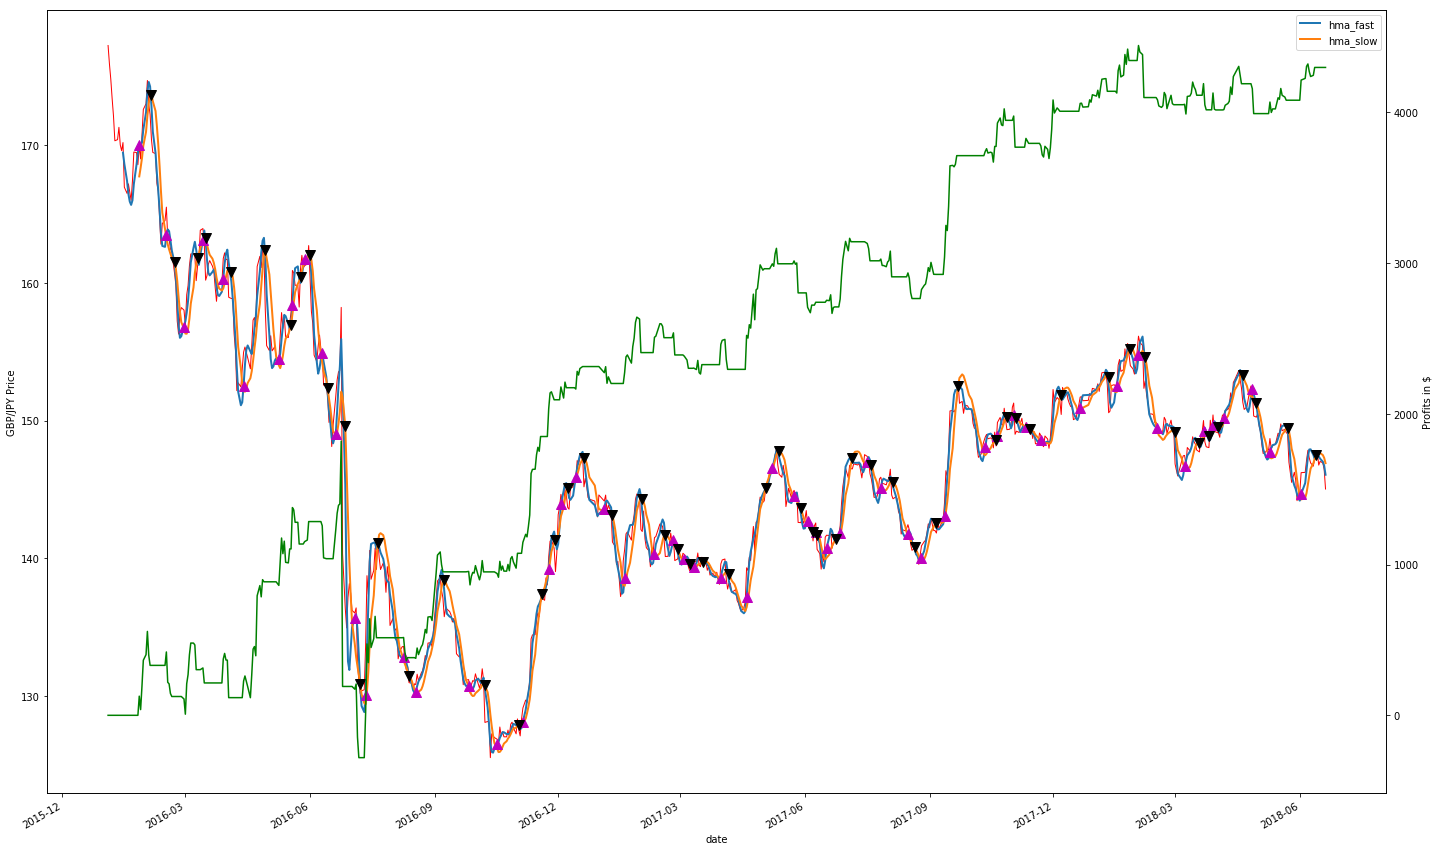

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(24,16))
ax1 = fig.add_subplot(111,  ylabel='GBP/JPY Price')

# Plotting market prices and moving averages
df['askclose'].plot(ax=ax1, color='r', lw=1.)
df[['hma_fast', 'hma_slow']].plot(ax=ax1, lw=2.)

# Placing purple markers for position entry
ax1.plot(df.loc[df.position == 1.0].index, 
         df.hma_fast[df.position == 1.0],
         '^', markersize=10, color='m')

# Placing black markers for position exit
ax1.plot(df.loc[df.position == -1.0].index, 
         df.hma_slow[df.position == -1.0],
         'v', markersize=10, color='k')

# Plotting of returns
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel('Profits in $')
ax2.plot(df['total'], color = 'green')

plt.show()

Graph of Hull MA strategy above shows fewer lags than EMA strategy